In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import numpy as np


In [8]:
train_dir = 'defect_dataset_1/NEU-DET/train/images'
val_dir = 'defect_dataset_1/NEU-DET/validation/images'

batch_size = 32
img_height = 200
img_width = 200

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 1441 files belonging to 7 classes.
Found 362 files belonging to 7 classes.
Classes: ['.ipynb_checkpoints', 'crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming train_ds, val_ds, class_names are already loaded as you shared

# Normalize images (scale pixel values to [0,1])
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Define model
num_classes = len(class_names)
img_height, img_width = 200, 200

model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# After training, print final accuracy
final_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Training accuracy: {final_acc:.4f}")
print(f"Validation accuracy: {final_val_acc:.4f}")


Epoch 1/10
46/46 [==============================] - 55s 1s/step - loss: 1.6896 - accuracy: 0.2783 - val_loss: 1.1827 - val_accuracy: 0.5028
Epoch 2/10
46/46 [==============================] - 51s 1s/step - loss: 0.9857 - accuracy: 0.5885 - val_loss: 1.0103 - val_accuracy: 0.6851
Epoch 3/10
46/46 [==============================] - 49s 1s/step - loss: 0.6488 - accuracy: 0.7661 - val_loss: 1.1725 - val_accuracy: 0.4641
Epoch 4/10
46/46 [==============================] - 49s 1s/step - loss: 0.7689 - accuracy: 0.7071 - val_loss: 1.6790 - val_accuracy: 0.4890
Epoch 5/10
46/46 [==============================] - 50s 1s/step - loss: 0.5300 - accuracy: 0.8078 - val_loss: 0.5614 - val_accuracy: 0.7762
Epoch 6/10
46/46 [==============================] - 51s 1s/step - loss: 0.3160 - accuracy: 0.8945 - val_loss: 0.5522 - val_accuracy: 0.8039
Epoch 7/10
46/46 [==============================] - 51s 1s/step - loss: 0.2444 - accuracy: 0.9237 - val_loss: 0.6124 - val_accuracy: 0.7680
Epoch 8/10
46/46 [==

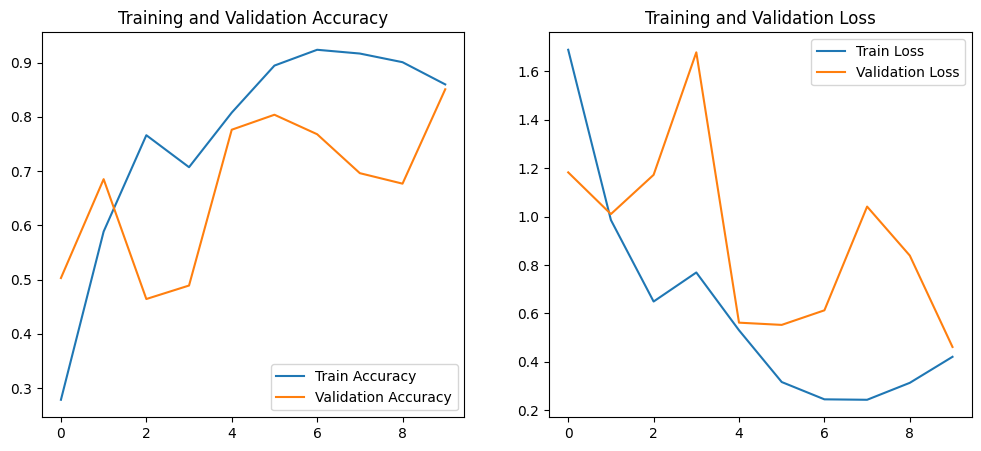

In [11]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training(history)


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze base model initially

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes)(x)

transfer_model = Model(inputs, outputs)

transfer_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
46/46 [==============================] - 32s 638ms/step - loss: 0.3514 - accuracy: 0.9049 - val_loss: 0.0607 - val_accuracy: 0.9917
Epoch 2/10
46/46 [==============================] - 29s 620ms/step - loss: 0.0274 - accuracy: 0.9951 - val_loss: 0.0538 - val_accuracy: 0.9890
Epoch 3/10
46/46 [==============================] - 29s 622ms/step - loss: 0.0136 - accuracy: 0.9986 - val_loss: 0.0410 - val_accuracy: 0.9890
Epoch 4/10
46/46 [==============================] - 29s 627ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0426 - val_accuracy: 0.9862
Epoch 5/10
46/46 [==============================] - 29s 627ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9862
Epoch 6/10
46/46 [==============================] - 29s 633ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 0.9862
Epoch 7/10
46/46 [==============================] - 29s 634ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9890

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs

transfer_fine_tune_history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=transfer_history.epoch[-1]
)


Epoch 10/20
 5/46 [==>...........................] - ETA: 37s - loss: 0.0085 - accuracy: 0.9937

In [13]:
!pip install -q tensorflow-model-optimization


In [14]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 32
epochs = 10
validation_steps = len(val_ds)

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.30,
        final_sparsity=0.80,
        begin_step=0,
        end_step=epochs * len(train_ds))
}

pruned_model = prune_low_magnitude(transfer_model, **pruning_params)

pruned_model.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./pruning_logs')
]

pruned_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/10
46/46 [==============================] - 37s 670ms/step - loss: 0.0059 - accuracy: 0.9993 - val_loss: 0.0484 - val_accuracy: 0.9779
Epoch 2/10
46/46 [==============================] - 30s 639ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 0.9862
Epoch 3/10
46/46 [==============================] - 38s 824ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9834
Epoch 4/10
46/46 [==============================] - 31s 662ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 0.9917
Epoch 5/10
46/46 [==============================] - 33s 713ms/step - loss: 0.0066 - accuracy: 0.9993 - val_loss: 0.0189 - val_accuracy: 0.9945
Epoch 6/10
46/46 [==============================] - 32s 696ms/step - loss: 0.0040 - accuracy: 0.9986 - val_loss: 0.0144 - val_accuracy: 0.9945
Epoch 7/10
46/46 [==============================] - 31s 671ms/step - loss: 0.0112 - accuracy: 0.9965 - val_loss: 0.0365 - val_accuracy: 0.9862

In [15]:
import tensorflow_model_optimization as tfmot
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='defect_model_quantized.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def run_tflite_inference(image):
    # Preprocess input image
    input_shape = input_details[0]['shape']
    img = tf.image.resize(image, (img_height, img_width))
    img = tf.expand_dims(img, axis=0)
    img = tf.cast(img, tf.float32) / 255.0

    interpreter.set_tensor(input_details[0]['index'], img.numpy())
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output[0])
    return class_names[predicted_class]

# Example usage
# image_tensor = tf.io.decode_image(tf.io.read_file('path_to_some_image.jpg'))
# predicted_label = run_tflite_inference(image_tensor)
# print("Predicted defect class:", predicted_label)


In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the quantized model
with open('defect_model_quantized.tflite', 'wb') as f:
    f.write(tflite_model)

print("Quantized TFLite model saved.")


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmp4nh8kac9\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmp4nh8kac9\assets


Quantized TFLite model saved.


In [17]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='defect_model_quantized.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def run_tflite_inference(image):
    # Preprocess input image
    input_shape = input_details[0]['shape']
    img = tf.image.resize(image, (img_height, img_width))
    img = tf.expand_dims(img, axis=0)
    img = tf.cast(img, tf.float32) / 255.0

    interpreter.set_tensor(input_details[0]['index'], img.numpy())
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output[0])
    return class_names[predicted_class]




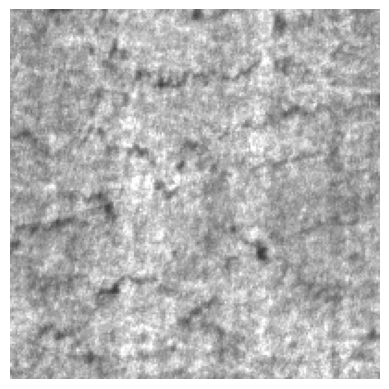

Predicted class: crazing, Confidence (logits): 7.4318


In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='defect_model_quantized.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def load_and_preprocess_image(img_path, img_height=200, img_width=200):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0
    return img

def predict_tflite(img_path):
    img = load_and_preprocess_image(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    input_data = np.expand_dims(img.numpy(), axis=0).astype(np.float32)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred_class = np.argmax(output_data[0])
    confidence = output_data[0][pred_class]
    
    print(f"Predicted class: {class_names[pred_class]}, Confidence (logits): {confidence:.4f}")

# Usage example
img_path = 'defect_dataset_1/NEU-DET/validation/images/crazing/crazing_243.jpg'
predict_tflite(img_path)


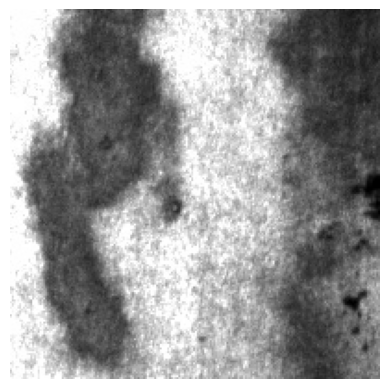

Predicted class: patches, Confidence (logits): 12.5490


In [19]:
img_path = 'defect_dataset_1/NEU-DET/validation/images/patches/patches_295.jpg'
predict_tflite(img_path)

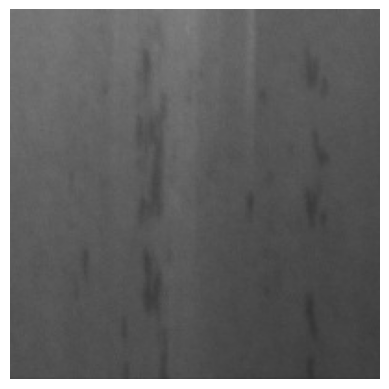

Predicted class: inclusion, Confidence (logits): 10.4755


In [20]:
img_path = 'defect_dataset_1/NEU-DET/validation/images/inclusion/inclusion_275.jpg'
predict_tflite(img_path)

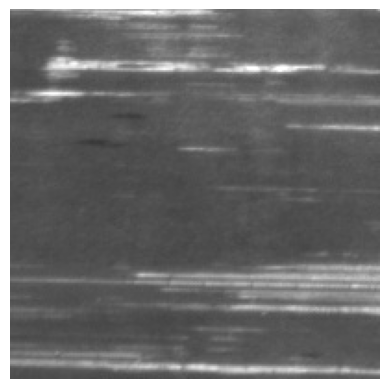

Predicted class: scratches, Confidence (logits): 19.2345


In [21]:
img_path = 'defect_dataset_1/NEU-DET/validation/images/scratches/scratches_273.jpg'
predict_tflite(img_path)